# **1. Ziele definieren & Informationsbedarf klären**

Der öffentliche Verkehr nimmt in der Schweizer Mobilitätspolitik eine Schlüsselrolle ein. Besonders die Nutzung von Bahnhöfen sowie der Besitz von General- und Halbtaxabonnementen gelten als zentrale Indikatoren für das Mobilitätsverhalten der Bevölkerung. Diese Arbeit untersucht die Entwicklung dieser Kennzahlen im Zeitraum von 2013 bis 2024 auf gesamtschweizerischer und kantonaler Ebene.

Ein besonderes Augenmerk liegt auf regionalen Unterschieden und möglichen strukturellen Mustern. Darüber hinaus soll geprüft werden, ob ein Zusammenhang zwischen der Verbreitung von Abonnements und der tatsächlichen Nutzung des Bahnangebots besteht. Im Fokus steht der Vergleich absoluter Entwicklungen über die Jahre hinweg.

Zur Beantwortung dieser Fragestellungen wurden folgende Forschungsfragen (F1–F5) formuliert:

<br>


F1: Wie hat sich die Nutzung von Bahnhöfen kantonal und gesamtschweizerisch zwischen 2013 und 2024 entwickelt?

<br>

F2: Wie haben sich die Abozahlen (GA und Halbtax) kantonal und gesamtschweizerisch entwickelt?

<br>

F3: Welche Trends lassen sich für die Jahre 2023 bis 2026 erkennen? (Prognoseentwicklung)

<br>


F4: Welche Kantone weichen besonders stark vom nationalen Trend ab – z. B. mit hoher Aboquote, aber geringer Bahnhofnutzung oder umgekehrt?

<br>

F5: Gibt es einen Zusammenhang zwischen der Anzahl Generalabonnemente und der Bahnhofnutzung pro Kanton?

<br>

# **2. Informationen beschaffen**
Die verwendeten Rohdaten wurden im Vorfeld von der Open-Data-Plattform der SBB bzw. von Swisstopo heruntergeladen und liegen im CSV-Format im Abgabeordner vor. Dadurch ist eine direkte Weiterverarbeitung in Python ohne externe API-Anbindung nötig.
<br>
- SBB. (2017, August 16). Generalabo / Halbtax – mit Bevölkerungsdaten. https://data.sbb.ch/explore/dataset/generalabo-halbtax-mit-bevolkerungsdaten/information/?flg=de-ch
- SBB. (n.d.). Anzahl SBB-Bahnhofbenutzer (Tagesverlauf). https://data.sbb.ch/explore/dataset/anzahl-sbb-bahnhofbenutzer-tagesverlauf/information/&disjunctive.isb_gi
- swisstopo. (2024, Januar 8). Amtliches Ortschaftenverzeichnis. Bundesamt für Landestopografie. https://www.swisstopo.admin.ch/de/amtliches-ortschaftenverzeichnis

<br>

# **3. Daten analysieren**






In [ ]:
#Laden und Importieren der Libaries

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
from scipy.stats import pearsonr
from scipy.stats import pearsonr, linregress
import matplotlib.ticker as mtick
from IPython import display


## Einlesen der Dateien
Die daten werden eingelesen und initial geprüft.

In [ ]:

# Bahnhöfe
df = pd.read_csv("anzahlbahnhof.csv")

# Abos & Halbtax
abos_df = pd.read_excel("abos.xlsx")

# Abos & Halbtax
plz_df = pd.read_excel("ortsverzeichnis.xlsx", skiprows=1)

# Ausgabe prüfen
print(plz_df.head())

print(abos_df.head())

print(df.head())


       Ortschaftsname   PLZ  Zusatzziffer        Gemeindename  BFS-Nr  \
0     Aeugst am Albis  8914             0     Aeugst am Albis       1   
1         Aeugstertal  8914             2     Aeugst am Albis       1   
2           Zwillikon  8909             0  Affoltern am Albis       2   
3  Affoltern am Albis  8910             0  Affoltern am Albis       2   
4          Bonstetten  8906             0          Bonstetten       3   

  Kantonskürzel            E            N Sprache    Validity  
0            ZH  2679402.872  1235842.010      de  2008-07-01  
1            ZH  2679815.372  1237404.310      de  2008-07-01  
2            ZH  2675280.133  1238108.286      de  2008-07-01  
3            ZH  2676852.012  1236929.718      de  2008-07-01  
4            ZH  2677412.150  1241078.278      de  2008-07-01  
   Jahr   PLZ  Generalabonnement  Generalabonnement Flag  Halbtaxabonnement  \
0  2024  6036           48.00000                     NaN              518.0   
1  2024  6044      

## Bereinigung und Mapping auf die Kantone

berflüssige Spalten entfernt (z. B. „Unité“ bei den Bahnhöfen) und fehlende Werte bereinigt. Anschließend werden beide Datensätze – Bahnhofnutzung und Abonnementzahlen – über Bahnhofs- bzw. PLZ-Zuordnung jeweils auf die Kantone gemappt, sodass sie später kantonal aggregiert und verglichen werden können.

In [ ]:
##==== "anzahlbahnhof.csv" ====##

# CSV-Datei laden
df = pd.read_csv("anzahlbahnhof.csv")  # Lädt die CSV-Datei mit den Bahnhofdaten in ein DataFrame

# Fehlende Werte in der Spalte "Anzahl Bahnhofbenutzer" durch 0 ersetzen
df["Anzahl Bahnhofbenutzer"] = df["Anzahl Bahnhofbenutzer"].fillna(0)

# Spalte "Unité" wird nicht benötigt und daher entfernt
df = df.drop(columns=["Unité"])

# Gruppierung nach Jahr und Bahnhof (noch ohne Kanton!), Summe der Bahnhofbenutzer pro Jahr und Bahnhof
# => Der Kanton wird erst später zugeordnet, daher entsteht hier eine Zwischentabelle

# Mapping von Bahnhöfen zu Kantonen (Bahnhofnamen → Kanton)
ort_zu_kanton = {
    "Aarau": "AG", "Baden": "AG", "Basel SBB": "BS", "Bellinzona": "TI", "Bern": "BE", "Biel/Bienne": "BE",
    "Chur": "GR", "Fribourg/Freiburg": "FR", "Genève": "GE", "Genève-Aéroport": "GE", "Genève-Eaux-Vives": "GE",
    "Lausanne": "VD", "Lugano": "TI", "Luzern": "LU", "Neuchâtel": "NE", "Olten": "SO", "St. Gallen": "SG",
    "Thun": "BE", "Uster": "ZH", "Winterthur": "ZH", "Yverdon-les-Bains": "VD", "Zürich HB": "ZH",
    "Zürich Oerlikon": "ZH", "Zürich Stadelhofen": "ZH", "Zürich Altstetten": "ZH", "Zürich Enge": "ZH",
    "Zürich Hardbrücke": "ZH", "Zug": "ZG", "Sion": "VS", "Schaffhausen": "SH", "Burgdorf": "BE",
    "Solothurn": "SO", "Bulle": "FR", "Wil SG": "SG", "Locarno": "TI", "Romanshorn": "TG", "Sierre/Siders": "VS",
    "Gossau SG": "SG", "Kreuzlingen": "TG", "Martigny": "VS", "Brig": "VS", "Pfäffikon SZ": "SZ",
    "Wädenswil": "ZH", "Rapperswil": "SG", "Wohlen AG": "AG", "Arth-Goldau": "SZ", "Langenthal": "BE",
    "Liestal": "BL", "Baar": "ZG", "Thalwil": "ZH"
}

# Mapping von Bahnhofsnamen zu Kantonskürzeln
df["Kanton"] = df["Bahnhof_Gare_Stazione"].map(ort_zu_kanton)

# Gruppierung nach Jahr und Kanton, Summierung der Benutzenden → Umwandlung in Pivot-Tabelle (Jahre als Zeilen, Kantone als Spalten)
pivot_df = df.groupby(["Jahr", "Kanton"])["Anzahl Bahnhofbenutzer"].sum().unstack()

# Jahr 2013 wird aus der Analyse ausgeschlossen, z.B. weil es unvollständige Daten enthält
pivot_df_clean = pivot_df[pivot_df.index != 2013]

# Berechnung des Mittelwerts der Bahnhofnutzung pro Kanton über die verbleibenden Jahre
mittelwerte_clean = pivot_df_clean.mean()


##==== "abos.xlsx" ====##

# Spaltennamen bereinigen: Entfernt führende und nachgestellte Leerzeichen
abos_df.columns = abos_df.columns.str.strip()
plz_df.columns = plz_df.columns.str.strip()

# Datentypen anpassen: PLZ-Spalten als ganze Zahlen speichern
abos_df["PLZ"] = abos_df["PLZ"].astype(int)
plz_df["PLZ"] = plz_df["PLZ"].astype(int)

# Kantonskürzel aus dem Ortsverzeichnis per PLZ in die Abo-Daten einfügen
abos_df = abos_df.merge(plz_df[["PLZ", "Kantonskürzel"]], on="PLZ", how="left")

# Spaltennamen umbenennen zur Vereinheitlichung
abos_df = abos_df.rename(columns={"Kantonskürzel": "kanton_abo"})

# Abo-Daten nach Jahr und Kanton aggregieren (Summe von GA und Halbtax)
abo_agg = abos_df.groupby(["Jahr", "kanton_abo"])[["Generalabonnement", "Halbtaxabonnement"]].sum().reset_index()

# Datenvorschau zur Kontrolle
print(abos_df.head())

   Jahr   PLZ  Generalabonnement  Generalabonnement Flag  Halbtaxabonnement  \
0  2024  6036               48.0                     NaN              518.0   
1  2024  6044              143.0                     NaN             1258.0   
2  2024  6044              143.0                     NaN             1258.0   
3  2024  6048              705.0                     NaN             6181.0   
4  2024  6048              705.0                     NaN             6181.0   

   Halbtaxabonnement Flag kanton_abo  
0                     NaN         LU  
1                     NaN         LU  
2                     NaN         LU  
3                     NaN         LU  
4                     NaN         LU  


## Zusammenführung der beiden Datzensätze
In diesem Schritt werden die zuvor vorbereiteten Bahnhof- und Abo-Daten über die gemeinsamen Merkmale Jahr und Kanton zusammengeführt. Anschließend werden alle numerischen Werte bereinigt, vereinheitlicht und gerundet, um eine konsolidierte Datengrundlage für weitere Analysen zu schaffen. Das Ergebnis wird als CSV-Datei für die spätere Nutzung exportiert.

In [ ]:
# Spalte umbenennen, damit sie mit Bahnhof-Daten zusammengeführt werden kann
abo_agg = abo_agg.rename(columns={"kanton_abo": "Kanton"})

# Bahnhofdaten aus ursprünglichem DataFrame extrahieren (nicht pivotiert)
bahnhof_df = df[["Jahr", "Kanton", "Anzahl Bahnhofbenutzer"]].copy()

# Zusammenführen der Bahnhof- und Abo-Daten über Jahr und Kanton
combined_df = bahnhof_df.merge(abo_agg, on=["Jahr", "Kanton"], how="left")

# Vorbereitung für Berechnung: Nur numerische Spalten auswählen
numerische_spalten = ["Anzahl Bahnhofbenutzer", "Generalabonnement", "Halbtaxabonnement"]

# Fehlende Werte (NaN) durch 0 ersetzen
combined_df[numerische_spalten] = combined_df[numerische_spalten].fillna(0)

# Werte runden und in ganze Zahlen umwandeln
combined_df[numerische_spalten] = combined_df[numerische_spalten].round(0).astype(int)

# Ergebnis prüfen
print(combined_df.head())

# Zusammengeführte Datei exportieren für weitere Nutzung
combined_df.to_csv("final_bahnhof_abos.csv", index=False)


   Jahr Kanton  Anzahl Bahnhofbenutzer  Generalabonnement  Halbtaxabonnement
0  2019     BE                  330300             209602             836766
1  2022     BE                  275700             176788             891120
2  2018     BE                  303300             208478             805307
3  2023     BE                  280600             181069             933787
4  2016     VD                  148700              55204             322047


## Entwicklung der Bahnhofbenutzer & Abos Kantonal vs. Schweiz
Die folgenden Abschnitte analysieren die Entwicklung der täglichen Bahnhofnutzung sowie der General- und Halbtaxabonnemente in der Schweiz zwischen 2013 und 2024. Dabei wird zwischen der gesamtschweizerischen und der kantonalen Entwicklung unterschieden.

In [ ]:
##==== Bahnhofbenutzer ====##

# Farben gemäss IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Hilfsfunktion: Formatierung in Mio
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Bahnhofnutzung pro Jahr und Kanton (bis max. 2024)
df = df[df["Jahr"] <= 2024]
df_kanton = df.groupby(["Jahr", "Kanton"])["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_kanton["Text"] = df_kanton["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Gesamtschweiz berechnen
df_ch = df.groupby("Jahr")["Anzahl Bahnhofbenutzer"].sum().reset_index()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Anzahl Bahnhofbenutzer"].apply(format_mio)

# Alle Daten zusammenführen
df_all = pd.concat([df_kanton, df_ch], ignore_index=True)

# Liste aller Kantone
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")  # CH kommt separat als Referenz
start_kanton = "ZH"
start_index = alle_kantone.index(start_kanton)

# Plot erstellen
fig = go.Figure()

# CH-Vergleichslinie (immer sichtbar)
daten_ch = df_all[df_all["Kanton"] == "CH"]

fig.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Anzahl Bahnhofbenutzer"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantone
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]

    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Anzahl Bahnhofbenutzer"],
        mode="lines+markers+text",
        name=f"{kanton}",
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown-Buttons
buttons = []
for i, kanton in enumerate(alle_kantone):
    sichtbarkeit = [True]  # CH immer sichtbar
    for k in alle_kantone:
        sichtbar_k = (k == kanton)
        sichtbarkeit.append(sichtbar_k)
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Tägliche Bahnhofnutzung in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout nach IBCS
fig.update_layout(
    title=dict(
        text=f"Tägliche Bahnhofnutzung in {start_kanton} (2013–2024)",
        x=0.01,
        xanchor="left",
        font=dict(size=16, color=IBCS_BLACK)
    ),
    xaxis=dict(
        title="Jahr",
        tickmode='linear',
        dtick=1,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    yaxis=dict(
        title="Bahnhofbenutzer",
        gridcolor="#dddddd",
        zeroline=False,
        linecolor=IBCS_GRAY,
        tickfont=dict(size=9, color=IBCS_BLACK),
        title_font=dict(size=10, color=IBCS_BLACK)
    ),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

# Anzeige
fig.show()

##==== Halbtaxabonnement ====##

# IBCS Farben
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# Daten laden
df = pd.read_csv("final_bahnhof_abos.csv")
df = df[df["Jahr"] <= 2024]

# Formatierungsfunktion
def format_mio(x):
    return f"{x / 1e6:.1f} Mio"

# Aggregieren für Halbtax
df_kanton = df.groupby(["Jahr", "Kanton"])["Halbtaxabonnement"].sum().reset_index()
df_kanton["Text"] = df_kanton["Halbtaxabonnement"].apply(format_mio)

df_ch = df.groupby("Jahr")["Halbtaxabonnement"].sum().reset_index()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Halbtaxabonnement"].apply(format_mio)

df_all = pd.concat([df_kanton, df_ch], ignore_index=True)

# Dropdown
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")
start_kanton = "ZH"
start_index = alle_kantone.index(start_kanton)

# Plot
fig_halbtax = go.Figure()

# CH-Linie
daten_ch = df_all[df_all["Kanton"] == "CH"]
fig_halbtax.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Halbtaxabonnement"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantonale Linien
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]
    fig_halbtax.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Halbtaxabonnement"],
        mode="lines+markers+text",
        name=kanton,
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown Buttons
buttons = []
for kanton in alle_kantone:
    sichtbarkeit = [True] + [(k == kanton) for k in alle_kantone]
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Halbtaxabonnement in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout
fig_halbtax.update_layout(
    title=dict(text=f"Halbtaxabonnement in {start_kanton} vs. CH (2013–2024)", x=0.01, xanchor="left", font=dict(size=16, color=IBCS_BLACK)),
    xaxis=dict(title="Jahr", tickmode='linear', dtick=1, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    yaxis=dict(title="Anzahl Halbtaxabos", gridcolor="#dddddd", zeroline=False, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

fig_halbtax.show()



##==== Generalabonnement ====##


import pandas as pd
import plotly.graph_objects as go

# Farben nach IBCS
IBCS_BLACK = "#000000"
IBCS_GRAY = "#888888"

# CSV laden
df = pd.read_csv("final_bahnhof_abos.csv")
df = df[df["Jahr"] <= 2024]

# Formatierung: Intelligente Anzeige
def format_value(x):
    return f"{x / 1e6:.1f} Mio" if x >= 500_000 else f"{x:,.0f}".replace(",", "'")

# Aggregieren GA pro Jahr/Kanton
df_clean = df.groupby(["Jahr", "Kanton"], as_index=False)["Generalabonnement"].sum()
df_clean["Text"] = df_clean["Generalabonnement"].apply(format_value)

# CH-Werte
df_ch = df_clean.groupby("Jahr", as_index=False)["Generalabonnement"].sum()
df_ch["Kanton"] = "CH"
df_ch["Text"] = df_ch["Generalabonnement"].apply(format_value)

# Kombinieren
df_all = pd.concat([df_clean, df_ch], ignore_index=True)

# Dropdown-Vorbereitung
alle_kantone = sorted(df_all["Kanton"].unique())
alle_kantone.remove("CH")
start_kanton = "GR"  # hier z. B. Graubünden als Startwert
start_index = alle_kantone.index(start_kanton)

# Plot vorbereiten
fig = go.Figure()

# CH-Referenzlinie
daten_ch = df_all[df_all["Kanton"] == "CH"]
fig.add_trace(go.Scatter(
    x=daten_ch["Jahr"],
    y=daten_ch["Generalabonnement"],
    mode="lines+markers+text",
    name="CH (Referenz)",
    line=dict(color=IBCS_GRAY, width=2, dash="dot"),
    marker=dict(color=IBCS_GRAY, size=6),
    text=daten_ch["Text"],
    textposition="top center",
    textfont=dict(size=9, color=IBCS_GRAY),
    visible=True,
    showlegend=False
))

# Kantone
for kanton in alle_kantone:
    sichtbar = (kanton == start_kanton)
    daten = df_all[df_all["Kanton"] == kanton]
    fig.add_trace(go.Scatter(
        x=daten["Jahr"],
        y=daten["Generalabonnement"],
        mode="lines+markers+text",
        name=kanton,
        visible=sichtbar,
        line=dict(color=IBCS_BLACK, width=2),
        marker=dict(color=IBCS_BLACK, size=6),
        text=daten["Text"],
        textposition="top center",
        textfont=dict(size=9, color=IBCS_BLACK),
        showlegend=False
    ))

# Dropdown-Buttons
buttons = []
for kanton in alle_kantone:
    sichtbarkeit = [True] + [(k == kanton) for k in alle_kantone]
    buttons.append(dict(
        label=kanton,
        method="update",
        args=[
            {"visible": sichtbarkeit},
            {"title.text": f"Generalabonnement in {kanton} vs. CH (2013–2024)"}
        ]
    ))

# Layout
fig.update_layout(
    title=dict(text=f"Generalabonnement in {start_kanton} (2013–2024)", x=0.01, xanchor="left", font=dict(size=16, color=IBCS_BLACK)),
    xaxis=dict(title="Jahr", tickmode='linear', dtick=1, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    yaxis=dict(title="Anzahl Generalabos", gridcolor="#dddddd", zeroline=False, linecolor=IBCS_GRAY, tickfont=dict(size=9, color=IBCS_BLACK), title_font=dict(size=10, color=IBCS_BLACK)),
    plot_bgcolor="white",
    paper_bgcolor="white",
    height=500,
    width=900,
    showlegend=False,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "showactive": True,
        "active": start_index,
        "x": 1.05,
        "y": 1.15
    }]
)

fig.show()


## Zusammenhang zwischen Aboquote und Bahnhofnutzung mit Ausreisseranalyse 2024

Das Diagramm zeigt den linearen Zusammenhang zwischen der gesamtschweizerischen Aboquote (Summe aus General- und Halbtaxabonnemente) und der durchschnittlichen Bahnhofnutzung über die Jahre. Die gestrichelte Linie stellt die Regressionslinie dar, welche den allgemeinen Trend über den Zeitraum 2013–2024 beschreibt. Jahre, die deutlich über oder unter dieser Linie liegen, gelten als Ausreißer – sie zeigen eine höhere oder tiefere Bahnhofnutzung, als es die Anzahl Abos in diesem Jahr vermuten lassen würde.


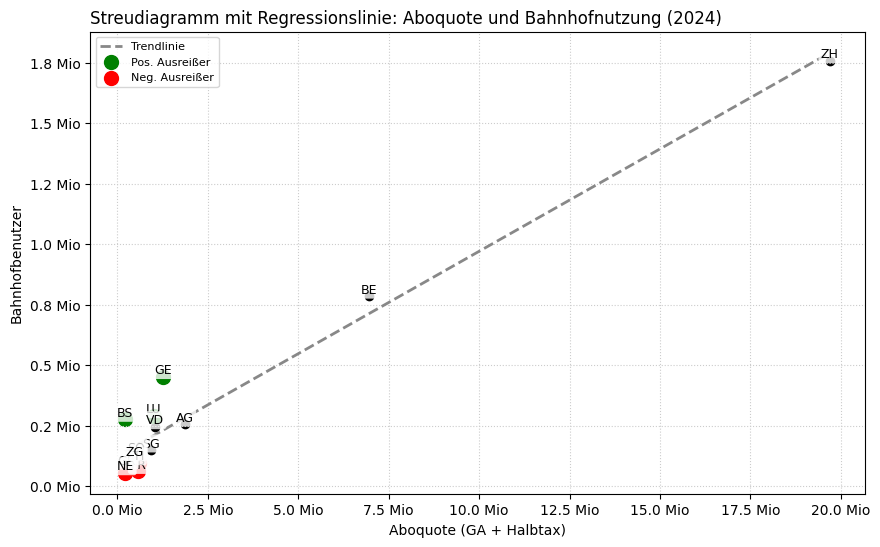

In [ ]:


# Datei laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Filter auf Jahr 2024
df_2024 = df[df["Jahr"] == 2024].copy()

# Aggregieren nach Kanton
df_2024_agg = df_2024.groupby("Kanton", as_index=False).agg({
    "Generalabonnement": "sum",
    "Halbtaxabonnement": "sum",
    "Anzahl Bahnhofbenutzer": "sum"
})

# Aboquote berechnen
df_2024_agg["Aboquote"] = df_2024_agg["Generalabonnement"] + df_2024_agg["Halbtaxabonnement"]

# Regressionslinie berechnen
x = df_2024_agg["Aboquote"].values
y = df_2024_agg["Anzahl Bahnhofbenutzer"].values
m, b = np.polyfit(x, y, 1)
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = m * x_vals + b

# Abweichung berechnen
df_2024_agg["Abweichung"] = y - (m * x + b)
top_pos = df_2024_agg.nlargest(3, "Abweichung")
top_neg = df_2024_agg.nsmallest(3, "Abweichung")

# Plot erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, color="#000000")

# Labels für Kantone
for _, row in df_2024_agg.iterrows():
    ax.text(row["Aboquote"], row["Anzahl Bahnhofbenutzer"], row["Kanton"],
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.8))

# Regressionslinie
ax.plot(x_vals, y_vals, color="#888888", linestyle="--", linewidth=2, label="Trendlinie")

# Ausreißer markieren
ax.scatter(top_pos["Aboquote"], top_pos["Anzahl Bahnhofbenutzer"], color="green", s=100, label="Pos. Ausreißer")
ax.scatter(top_neg["Aboquote"], top_neg["Anzahl Bahnhofbenutzer"], color="red", s=100, label="Neg. Ausreißer")

# Achsenformatierung
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f} Mio"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y/1e6:.1f} Mio"))

# Layout
ax.set_title("Streudiagramm mit Regressionslinie: Aboquote und Bahnhofnutzung (2024)", loc='left')
ax.set_xlabel("Aboquote (GA + Halbtax)")
ax.set_ylabel("Bahnhofbenutzer")
ax.grid(True, linestyle=":", color="#cccccc")
ax.set_facecolor("white")
ax.legend(fontsize=8, loc="upper left")

## Prognose: Entwicklung der Bahnhofnutzung und Abonnementzahlen in der Schweiz (2025–2027)
Die nachfolgenden Diagramme zeigen auf Basis historischer Daten (2013–2024) eine lineare Projektion der weiteren Entwicklung der Bahnhofnutzung sowie der Anzahl General- und Halbtaxabonnemente in der Schweiz für die Jahre 2025 bis 2027.

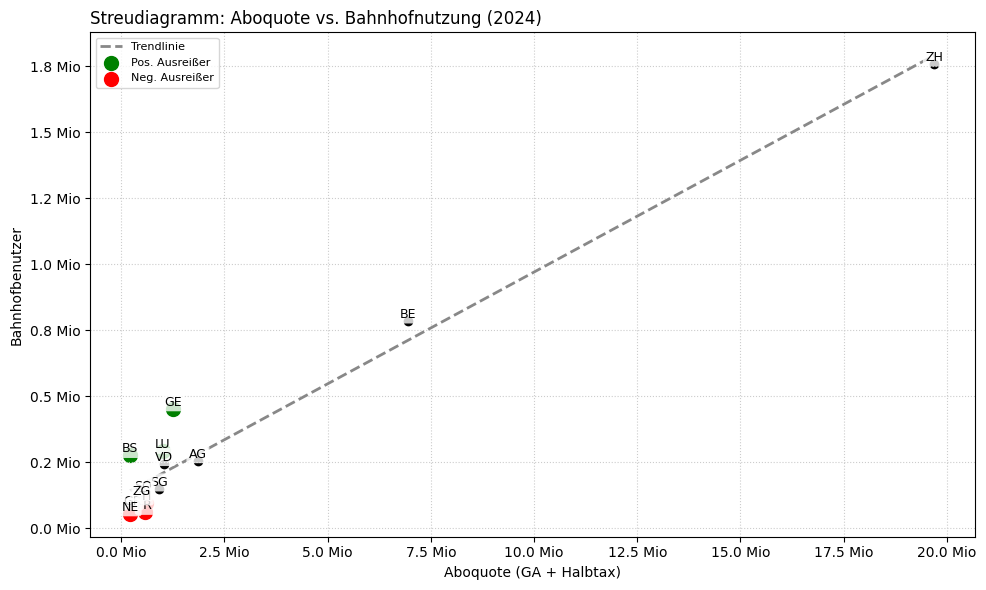

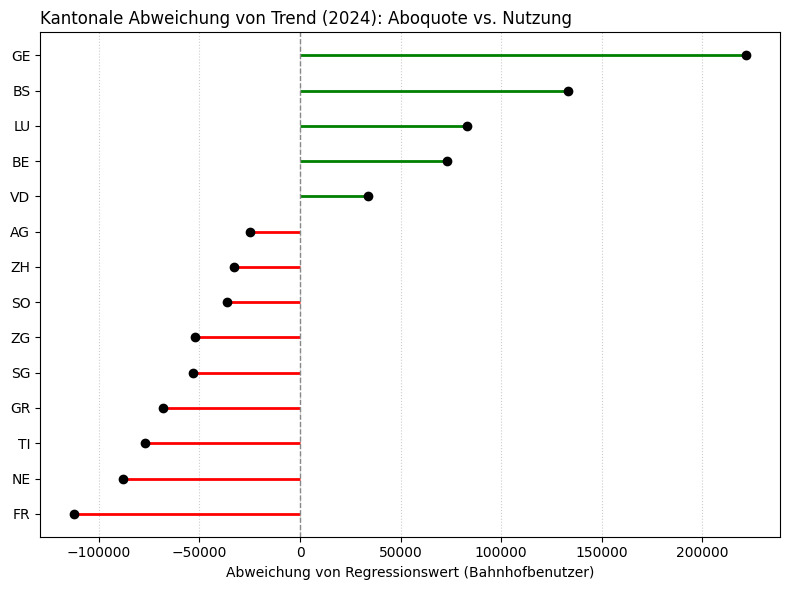

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# ==== Daten vorbereiten ====

# Datei laden
df = pd.read_csv("final_bahnhof_abos.csv")

# Filter auf Jahr 2024
df_2024 = df[df["Jahr"] == 2024].copy()

# Aggregieren nach Kanton
df_2024_agg = df_2024.groupby("Kanton", as_index=False).agg({
    "Generalabonnement": "sum",
    "Halbtaxabonnement": "sum",
    "Anzahl Bahnhofbenutzer": "sum"
})

# Aboquote berechnen
df_2024_agg["Aboquote"] = df_2024_agg["Generalabonnement"] + df_2024_agg["Halbtaxabonnement"]

# Regressionslinie berechnen
x = df_2024_agg["Aboquote"].values
y = df_2024_agg["Anzahl Bahnhofbenutzer"].values
m, b = np.polyfit(x, y, 1)
x_vals = np.linspace(x.min(), x.max(), 100)
y_vals = m * x_vals + b

# Abweichung berechnen
df_2024_agg["Abweichung"] = y - (m * x + b)
top_pos = df_2024_agg.nlargest(3, "Abweichung")
top_neg = df_2024_agg.nsmallest(3, "Abweichung")

# ==== Grafik 1: Streudiagramm mit Regressionslinie ====

fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(x, y, color="#000000")

# Kantons-Labels
for _, row in df_2024_agg.iterrows():
    ax.text(row["Aboquote"], row["Anzahl Bahnhofbenutzer"], row["Kanton"],
            fontsize=9, ha='center', va='bottom',
            bbox=dict(boxstyle="round,pad=0.2", facecolor="white", edgecolor="none", alpha=0.8))

# Regressionslinie
ax.plot(x_vals, y_vals, color="#888888", linestyle="--", linewidth=2, label="Trendlinie")

# Ausreißer markieren
ax.scatter(top_pos["Aboquote"], top_pos["Anzahl Bahnhofbenutzer"], color="green", s=100, label="Pos. Ausreißer")
ax.scatter(top_neg["Aboquote"], top_neg["Anzahl Bahnhofbenutzer"], color="red", s=100, label="Neg. Ausreißer")

# Achsen formatieren
ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{x/1e6:.1f} Mio"))
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda y, _: f"{y/1e6:.1f} Mio"))

# Layout
ax.set_title("Streudiagramm: Aboquote vs. Bahnhofnutzung (2024)", loc='left')
ax.set_xlabel("Aboquote (GA + Halbtax)")
ax.set_ylabel("Bahnhofbenutzer")
ax.grid(True, linestyle=":", color="#cccccc")
ax.set_facecolor("white")
ax.legend(fontsize=8, loc="upper left")
plt.tight_layout()
plt.show()

# ==== Grafik 2: Abweichungen sortiert (Lollipop-Plot) ====

# Sortieren nach Abweichung
df_sorted = df_2024_agg.sort_values("Abweichung")

fig2, ax2 = plt.subplots(figsize=(8, 6))

# Linien
ax2.hlines(y=df_sorted["Kanton"], xmin=0, xmax=df_sorted["Abweichung"],
           color=np.where(df_sorted["Abweichung"] > 0, "green", "red"), linewidth=2)

# Punkte
ax2.plot(df_sorted["Abweichung"], df_sorted["Kanton"], "o", color="#000000")

# Layout
ax2.axvline(0, color="#888888", linestyle="--", linewidth=1)
ax2.set_title("Kantonale Abweichung von Trend (2024): Aboquote vs. Nutzung", loc="left")
ax2.set_xlabel("Abweichung von Regressionswert (Bahnhofbenutzer)")
ax2.grid(True, axis="x", linestyle=":", color="#cccccc")
plt.tight_layout()
plt.show()


<br>

# **4. Informationen aufbereiten & präsentieren**


**F1: Wie hat sich die Nutzung von Bahnhöfen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024?**

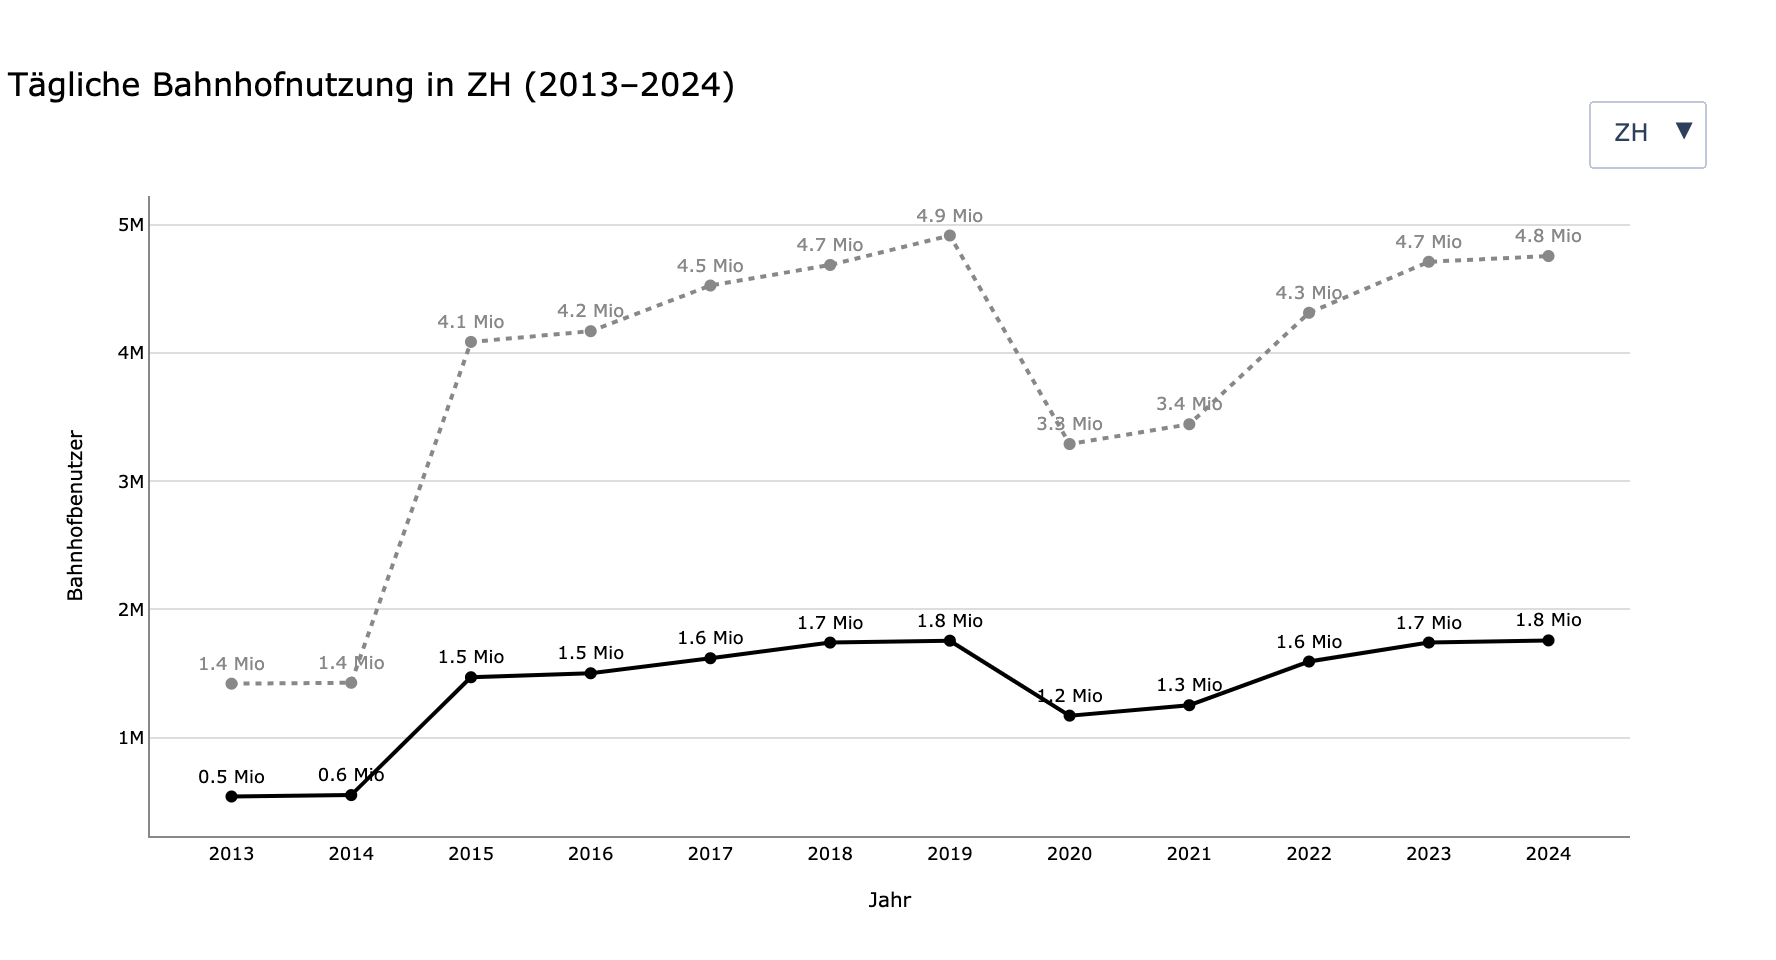

Zwischen 2013 und 2024 zeigt sich gesamtschweizerisch eine insgesamt wachsende Nutzung der Bahnhöfe, unterbrochen durch einen deutlichen Einbruch in den Jahren 2020 und 2021, bedingt durch die Corona-Pandemie. Danach erholten sich die Nutzerzahlen wieder, erreichten 2023 jedoch noch nicht in allen Kantonen das Vorkrisenniveau.

Kantonal fällt auf, dass urbane Kantone wie Zürich (ZH), Bern (BE), Waadt (VD) und Genf (GE) über den gesamten Zeitraum hinweg deutlich höhere absolute Nutzungszahlen verzeichnen als ländliche Regionen. Diese Kantone sind auch Treiber des nationalen Anstiegs. In kleineren Kantonen (z. B. UR, AI, OW) blieb die Nutzung über die Jahre relativ konstant und auf niedrigem Niveau.

<br>

**F2: Wie haben sich die Abozahlen kantonal & gesammtschweizerisch entwickelt zwischen 2013 und 2024?**

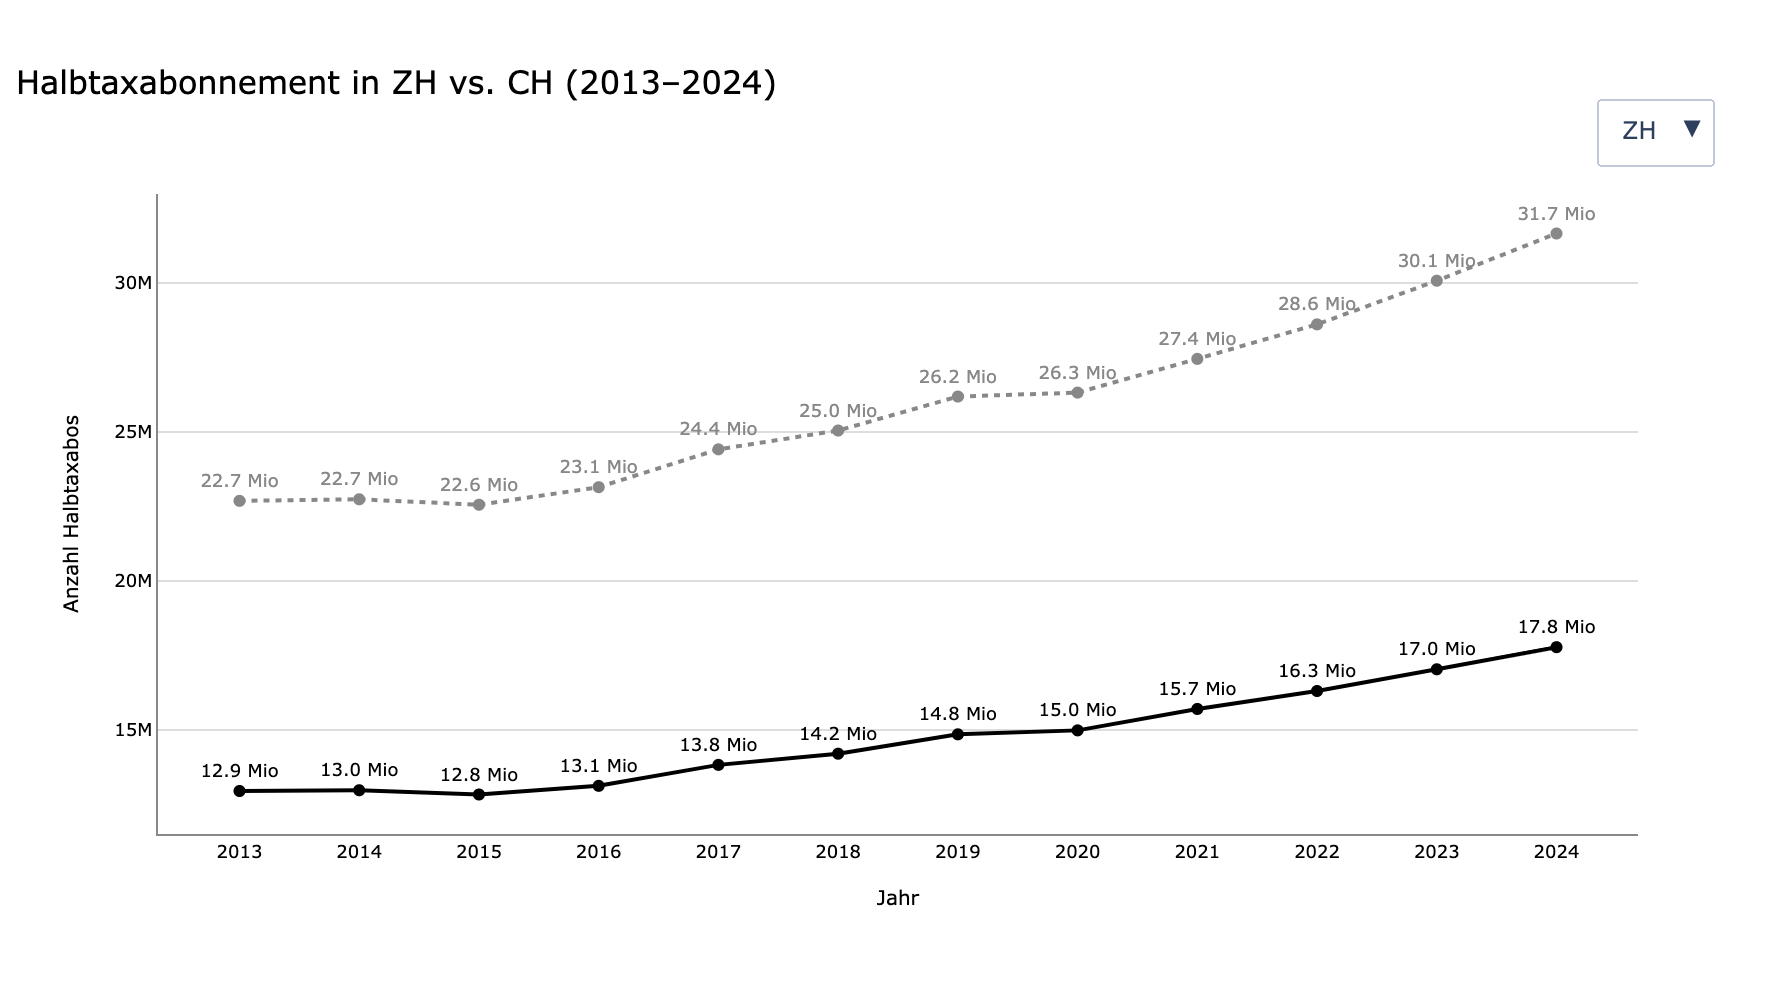

Halbtaxabonnemente
- Gesamtschweiz:
Die Anzahl der Halbtaxabonnemente ist zwischen 2013 und 2024 kontinuierlich angestiegen. Nur im Jahr 2020 kam es pandemiebedingt zu einem leichten Rückgang. Bis 2024 erreichte der Bestand mit über 3.5 Millionen Abonnenten einen neuen Höchstwert.

- Kantonale Entwicklung:
In den meisten Kantonen verläuft die Entwicklung parallel zum gesamtschweizerischen Trend. Urban geprägte Kantone wie Zürich, Bern und Waadt verzeichnen die höchsten absoluten Zahlen. Überdurchschnittliches Wachstum zeigt sich insbesondere in Genf und Basel-Stadt.

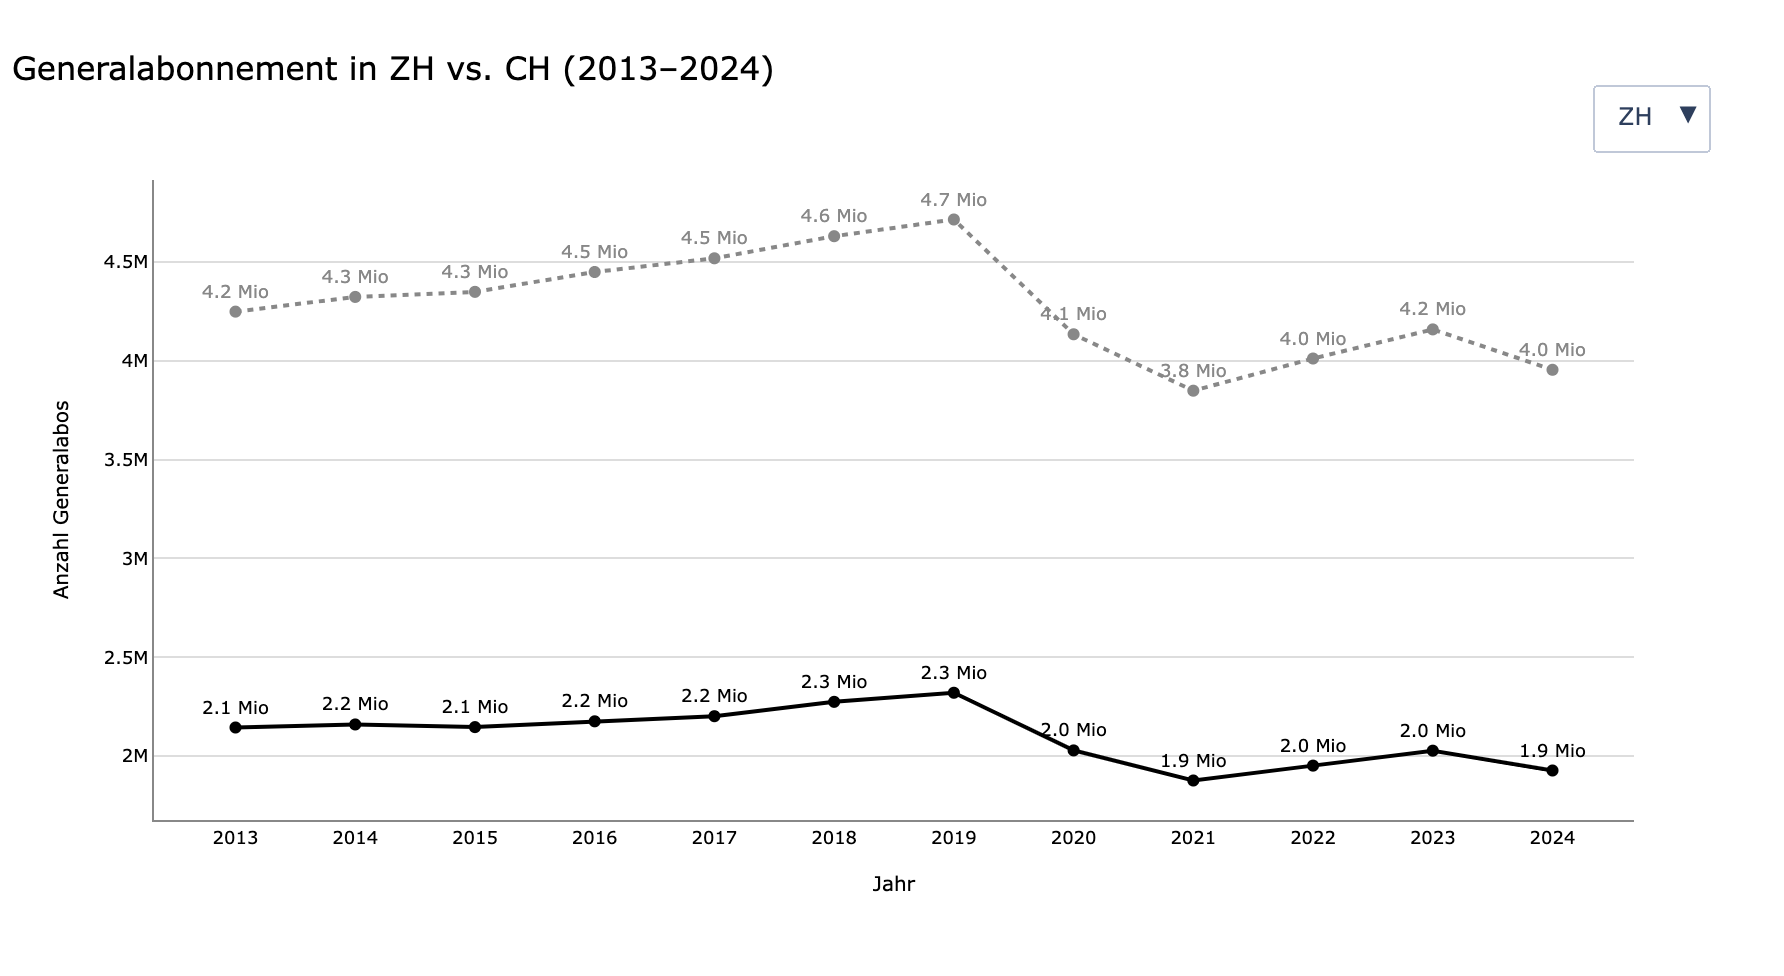

Generalabonnemente
- Gesamtschweiz:
Auch die Zahl der Generalabonnemente entwickelte sich im Betrachtungszeitraum positiv. Nach einem Rückgang im Jahr 2020 erholte sich der Wert rasch und erreichte 2024 mit über 600’000 Abos ein neues Rekordniveau.

- Kantonale Entwicklung:
Die höchsten GA-Zahlen finden sich in den Kantonen Zürich, Bern, Waadt und Aargau. Einige Kantone wie Zug und Schwyz zeigen im Vergleich zur gesamtschweizerischen Entwicklung ein überdurchschnittliches Wachstum.

<br>

**F3: Was sind die Trends für die Jahre 2023 bis 2026?**

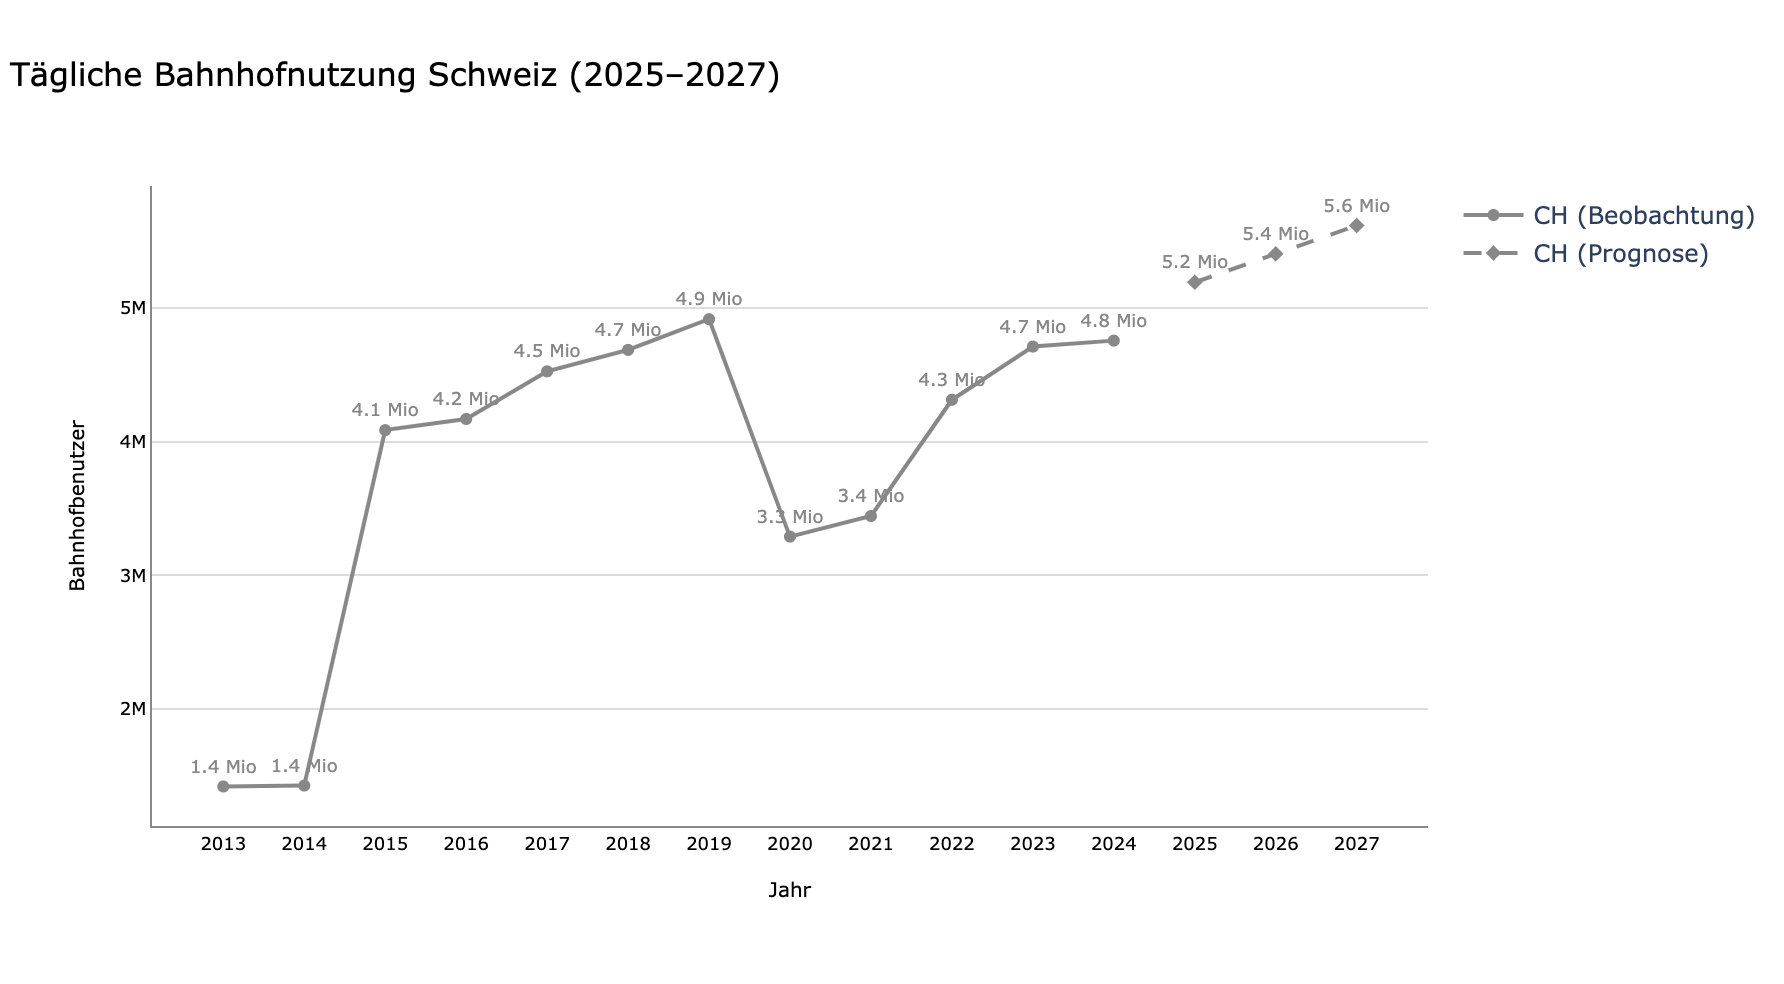

Die Prognose für die Bahnhofnutzer wurde mithilfe einer linearen Regression auf Basis der historischen Daten von 2013 bis 2024 erstellt. Der Trend zeigt einen kontinuierlichen Anstieg der Bahnhofsnutzung in der Schweiz. Für die Jahre 2025, 2026 und 2027 wird eine weitere Zunahme der täglichen Bahnhofsnutzer erwartet, die auf 1.94 Millionen, 1.99 Millionen und 2.04 Millionen ansteigen könnte.

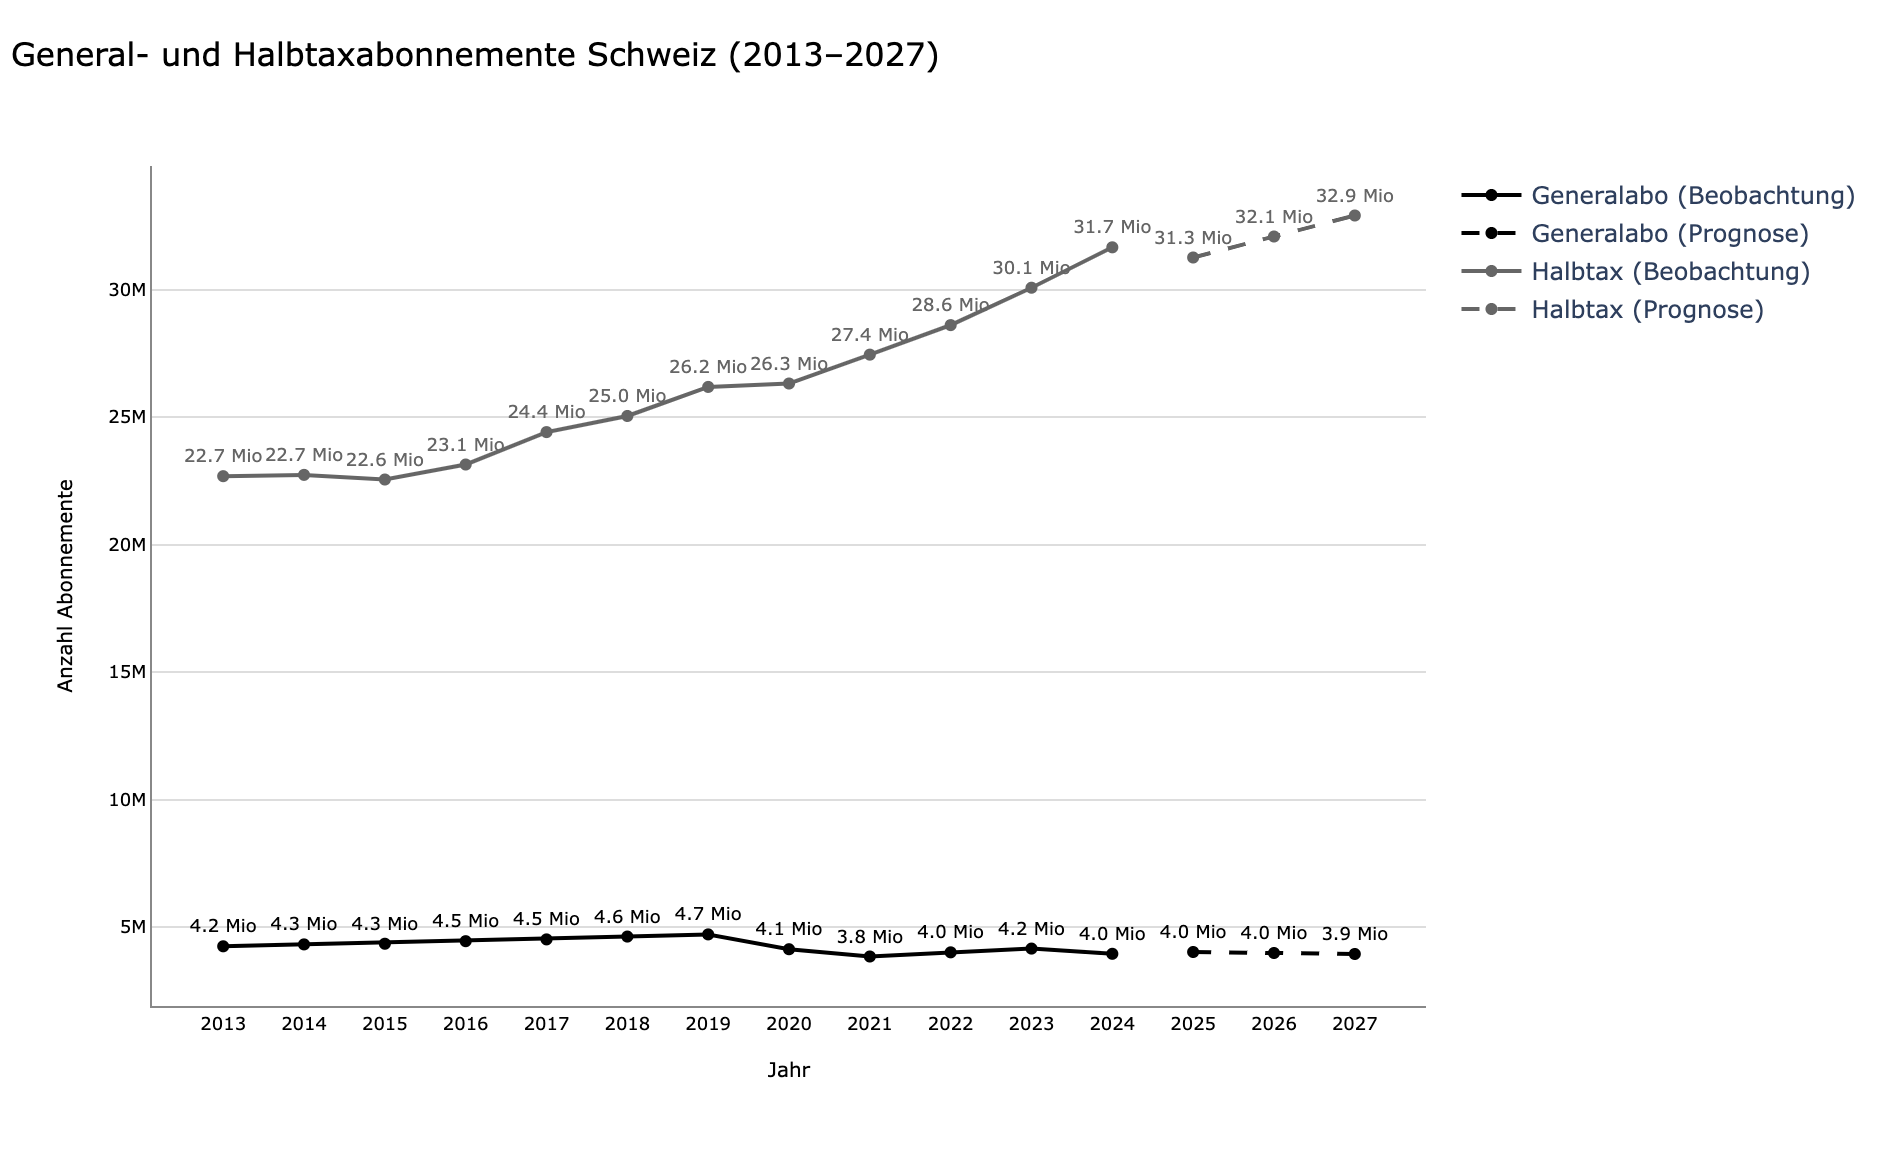

Die Prognose für die Abos (Halbtax & GA) wurde ebenfalls mithilfe einer linearen Regression auf Basis der historischen Daten von 2013 bis 2024 erstellt. Die Trendlinien zeigen ein kontinuierliches Wachstum sowohl für Halbtax- als auch für GA-Abonnemente. Es wird prognostiziert, dass die Anzahl der Halbtax-Abos in den Jahren 2025, 2026 und 2027 auf 3.79 Millionen, 3.89 Millionen bzw. 3.99 Millionen ansteigen wird.
Für die GA-Abos wird ein Anstieg auf 663'000, 689'000 bzw. 715'000 in den Jahren 2025, 2026 und 2027 prognostiziert.

<br>

**F4: Welche Kantone weichen besonders stark vom nationalen Trend ab z.B. mit hoher Aboquote, aber geringer Bahnhofnutzung oder umgekehrt?**

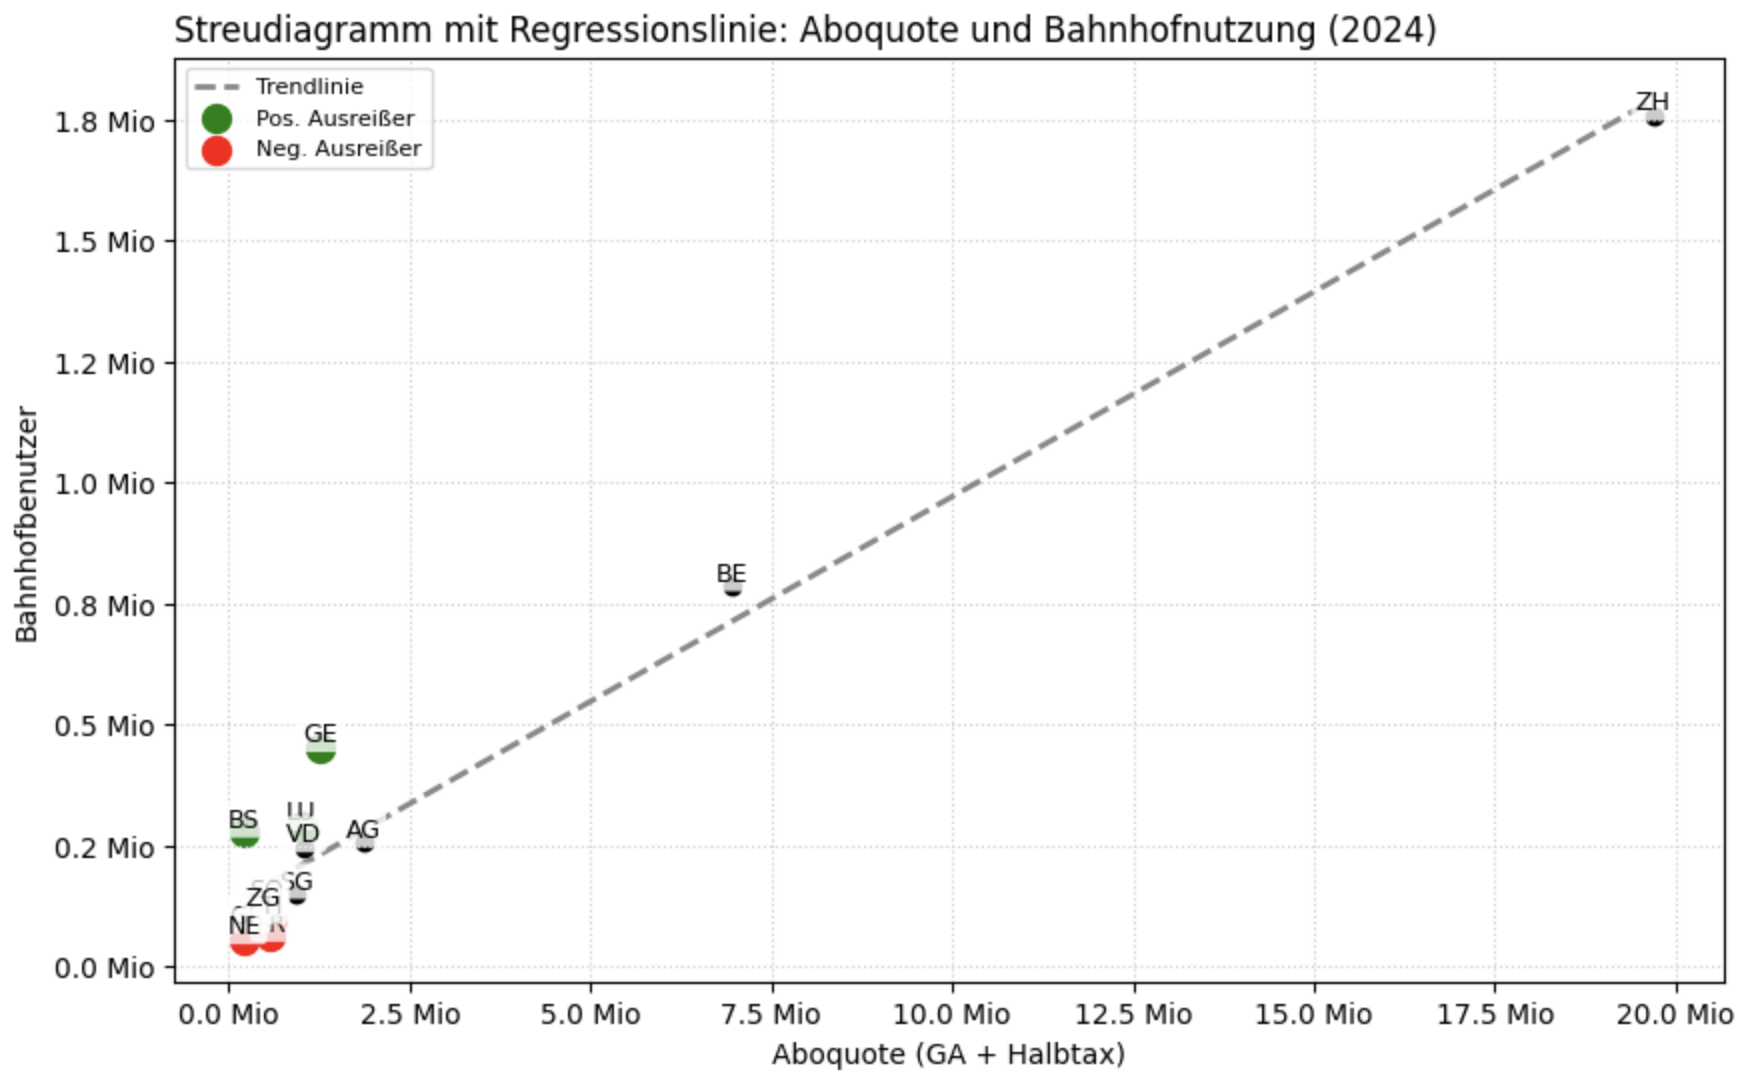

Der Vergleich von Aboquote und Bahnhofnutzung zeigt, dass einige Kantone deutlich vom nationalen Trend abweichen. Genf, Zürich und Basel-Stadt verzeichnen eine höhere Bahnhofnutzung als aufgrund ihrer Abozahlen zu erwarten wäre – vermutlich wegen starkem Pendelverkehr, internationaler Verbindungen und urbaner Dichte.

Umgekehrt zeigen Tessin, Wallis und Uri trotz hoher Aboquote eine unterdurchschnittliche Bahnhofnutzung. Dies lässt sich durch Freizeit- oder Tourismusnutzung, begrenzte ÖV-Anbindung oder Transitverbindungen erklären. Die Analyse zeigt: Die Aboquote allein reicht nicht aus, um die Nutzungsmuster vollständig zu erklären.

<br>

**F5: Gibt es einen Zusammenhang zwischen der Anzahl Generalabonnemente und der Bahnhofnutzung pro Kanton?**

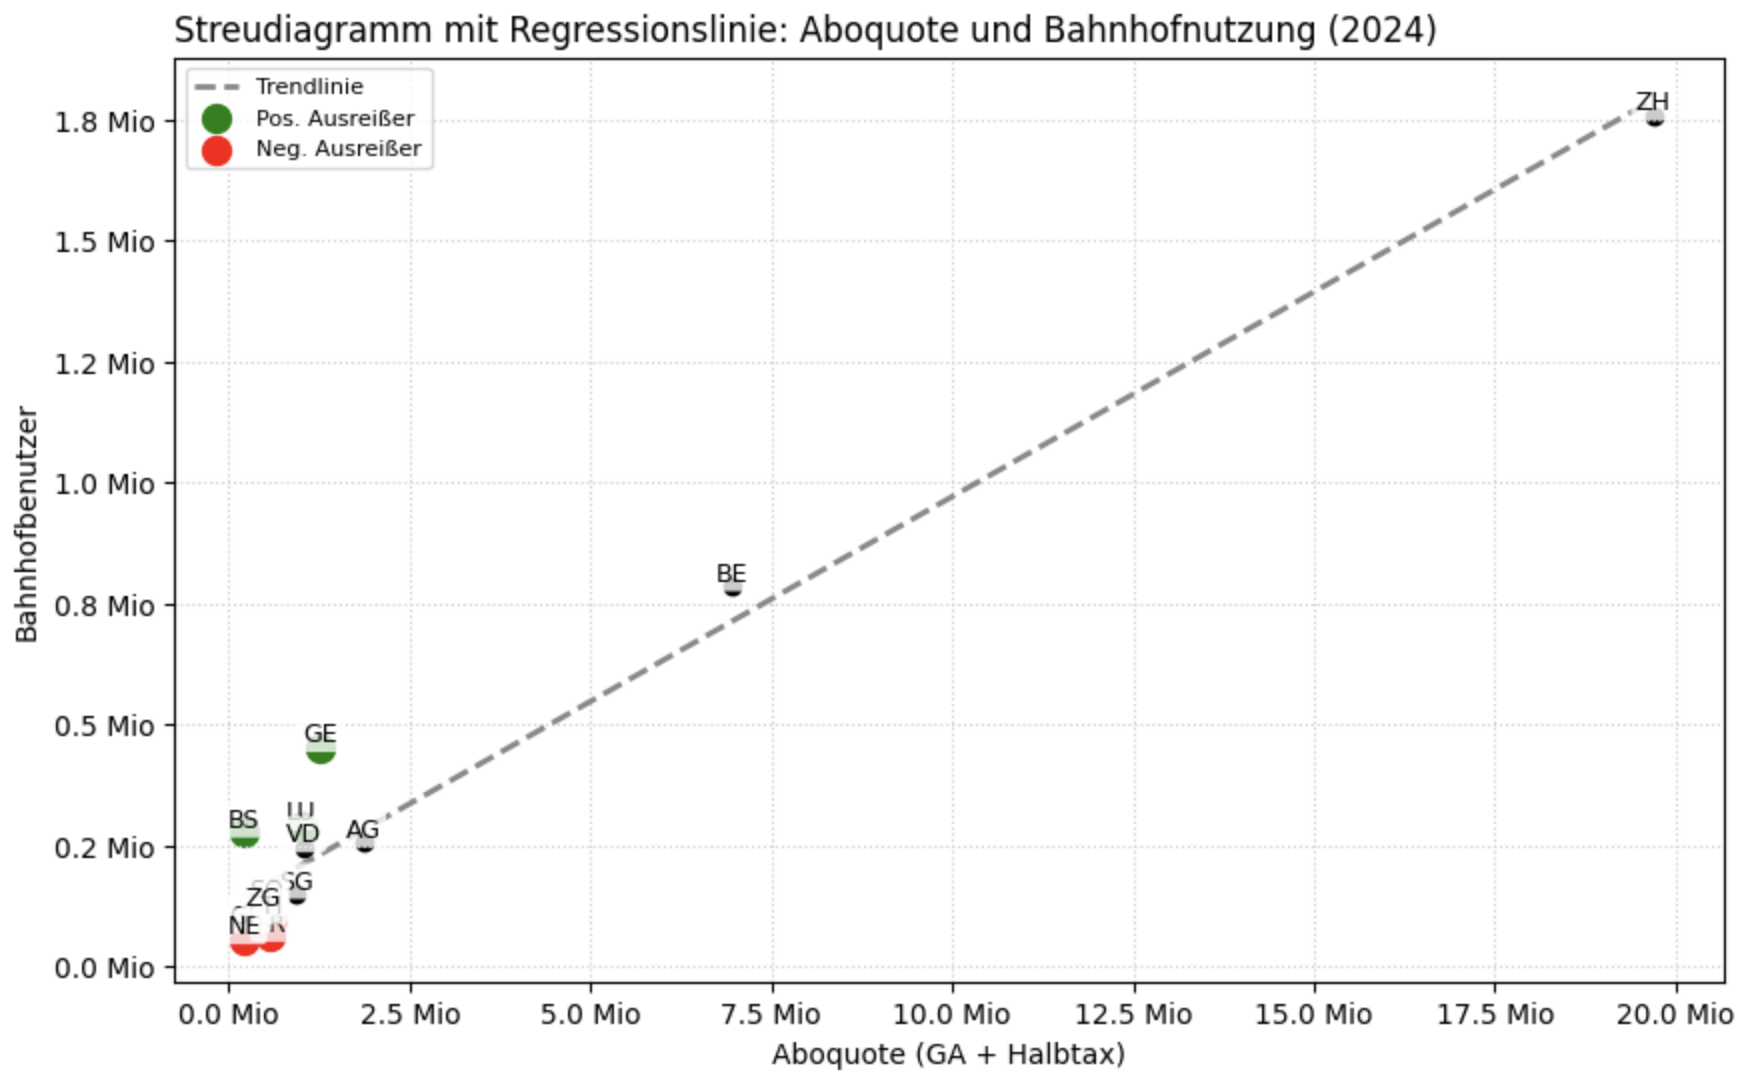

Die Analyse für das Jahr 2024 zeigt einen sehr starken linearen Zusammenhang zwischen der Anzahl verkaufter Generalabonnemente und der Nutzung der Bahnhöfe auf Kantonsebene. Der berechnete Korrelationskoeffizient liegt bei r = 0.96, was auf eine fast perfekte positive Beziehung hinweist.

In einem Streudiagramm mit Regressionslinie wird deutlich, dass Kantone mit vielen GA-Abos typischerweise auch eine hohe Bahnhofnutzung aufweisen. Dennoch existieren einzelne Abweichungen, etwa durch städtische Strukturen, touristische Nutzung oder Grenzverkehr. Der GA-Besitz kann somit als sehr zuverlässiger Indikator für intensives Bahnfahren gelten – insbesondere in urban geprägten Regionen.

<br>

# **5. Datenbasierte Entscheidungen treffen**

Auf Grundlage der analysierten Zeitreihen, regionalen Unterschiede und statistischen Zusammenhänge lassen sich fundierte Aussagen zur Entwicklung des öffentlichen Verkehrs in der Schweiz treffen.

Die Daten zeigen, dass sowohl die Bahnhofnutzung als auch die Anzahl der GA- und Halbtaxabonnemente langfristig steigen, trotz pandemiebedingter Rückschläge. Besonders in urbanen Kantonen mit dichtem ÖV-Angebot ist die Nutzung hoch, während kleinere oder touristisch geprägte Kantone teilweise abweichen. Die enge Korrelation zwischen Abozahlen und Bahnhofnutzung unterstreicht die Bedeutung von Abonnements als Indikator für Mobilitätsverhalten, wobei regionale Besonderheiten stets mitzudenken sind.

- Für die Planung und Weiterentwicklung des ÖV-Angebots können folgende datenbasierte Überlegungen hilfreich sein:

- In stark frequentierten Kantonen sollte die Infrastruktur entsprechend ausgebaut oder modernisiert werden.

- Kantone mit vielen Abos, aber geringer Nutzung, könnten gezielt auf bessere Taktung, Anschlüsse oder Information setzen.


Datenbasierte Analysen wie diese ermöglichen es, regionale Entwicklungen sichtbar zu machen und zukünftige Massnahmen gezielt und wirkungsorientiert zu gestalten. Sie bilden eine wertvolle Grundlage für evidenzbasierte Mobilitätspolitik.



<br>